In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("u.data",sep="\t",names = ["user_id","item_id","rating","timestamp"])

In [4]:
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
df.describe()

,user_id,item_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


0    196
1    186
2     22
3    244
4    166
5    298
6    115
7    253
8    305
9      6
Name: user_id, dtype: int64


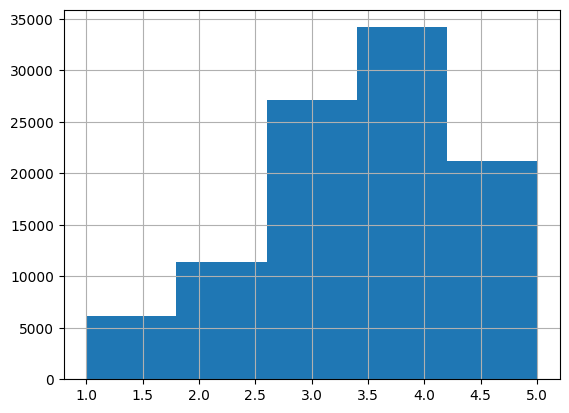

In [6]:
#ratings distribution
df['rating'].hist(bins=5)

print(df["user_id"][:10])

<Axes: >

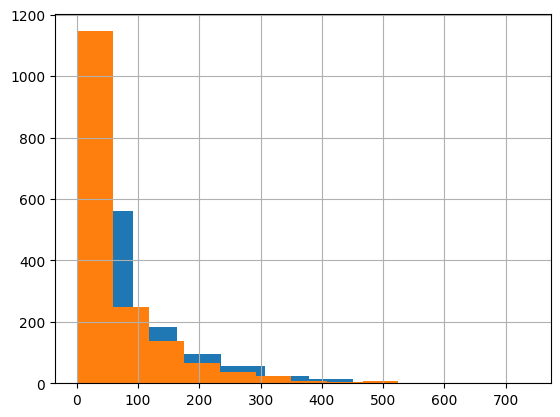

In [7]:
# Interactions per user/item
df['user_id'].value_counts().hist()
df['item_id'].value_counts().hist()

In [8]:
# Sparsity
n_users = df['user_id'].nunique()
n_items = df['item_id'].nunique()
sparsity = 1.0 - len(df) / (n_users * n_items)
print(f"Sparsity: {sparsity:.2%}")

Sparsity: 93.70%


In [9]:
print(df["user_id"])

0        196
1        186
2         22
3        244
4        166
        ... 
99995    880
99996    716
99997    276
99998     13
99999     12
Name: user_id, Length: 100000, dtype: int64


In [10]:
df["interactions"] = (df["rating"]>=4).astype(int) #regualarisation to handle the sparsity of the data. Ratings less than 4 is classified as 0 interaction

In [11]:
df.head()

,user_id,item_id,rating,timestamp,interactions
0,196,242,3,881250949,0
1,186,302,3,891717742,0
2,22,377,1,878887116,0
3,244,51,2,880606923,0
4,166,346,1,886397596,0


In [12]:
#function to map the userid idxs for re indexing.
user_ids = df["user_id"].unique()
item_ids = df["item_id"].unique()
def mapping(data):
    item_map = {}
    for idx,uid in enumerate(data):
        item_map[uid]=idx
    return item_map



print(user_ids[::10])
print(item_ids[::10])

[196  62 119 301 284 260  60 222  90  94 269 268  15  54 214 123 170 191
 263 285  45  75 173 205 108 124 202 227 204 209 323 326  86 335 344 358
 350 366 364 394 353 408 423 426 447 455 467 476 482 477 505 475 520 533
 539 540 558 579 585 570 603 609 624 634 635 655 665 676 672 694 675 678
 727 734 723 757 767 760 784 796 792 821 826 839 842 853 860 876 883 887
 905 914 927 938 930]
[ 242  257  392  246  304  432  288  416  366 1153  132  485  471  272
  117  164  673   48  408  106  318 1018  133  520  357  160  134 1086
  333  558  612  781   97   60  596  252  289  406  306   58  744 1099
  292 1246  632  586  509  686   99  696  461  122  583  477  162  663
 1178  875  737  747  283  949  335  316 1019 1350  657  778  904  207
  886  581 1218  192  157  525  745  244  863 1263  983  361   63 1222
 1315 1250  326  149 1324  689  636  958  481  266   74  887  270  925
  811 1314  691 1082  434 1424  444  913  964 1210  788 1050  383  940
  896 1500 1384  814 1123 1386  956  112  889

In [13]:
user_id_map = mapping(user_ids)
item_id_map = mapping(item_ids)    

In [14]:
#convert the user/item ids into consecutive integers
df["user_id_mapped"] = df["user_id"].map(user_id_map)
df["item_id_mapped"] = df["item_id"].map(item_id_map) 

#this reindexing is important for keras embedding layers



In [15]:
df.head()

,user_id,item_id,rating,timestamp,interactions,user_id_mapped,item_id_mapped
0,196,242,3,881250949,0,0,0
1,186,302,3,891717742,0,1,1
2,22,377,1,878887116,0,2,2
3,244,51,2,880606923,0,3,3
4,166,346,1,886397596,0,4,4


In [16]:
#drop the unneeded columns
df_keras = df[["user_id_mapped","item_id_mapped","interactions"]]

In [17]:
df_keras.head()

,user_id_mapped,item_id_mapped,interactions
0,0,0,0
1,1,1,0
2,2,2,0
3,3,3,0
4,4,4,0


In [18]:
from sklearn.model_selection import train_test_split
X= df_keras[["user_id_mapped","item_id_mapped"]]
y= df_keras[["interactions"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape



(80000, 2)

In [19]:
num_users = df_keras["user_id_mapped"].nunique() #unique values are important for keras embeddings
num_items = df["item_id_mapped"].nunique()

print(num_users)
print(num_items)


#the values of unique users and items shows that there are many non-unique user and items in this 1 million large dataset

943
1682


In [20]:
from keras.models import Model
from keras.layers import Input,Embedding,Flatten, Multiply, Concatenate, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

#inputs
user_input = Input(shape=(1,))
item_input = Input(shape=(1,))

#embeddings
embedding_dim = 32

user_embedding_gmf = Embedding(num_users,embedding_dim)(user_input)
item_embedding_gmf = Embedding(num_items,embedding_dim)(item_input)


user_embedding_mlp = Embedding(num_users,embedding_dim)(user_input)
item_embedding_mlp = Embedding(num_items,embedding_dim)(item_input)

#flatten
user_vec_gmf = Flatten()(user_embedding_gmf)
item_vec_gmf = Flatten()(item_embedding_gmf)

user_vec_mlp = Flatten()(user_embedding_mlp)
item_vec_mlp = Flatten()(item_embedding_mlp)


#gmf branch
gmf = Multiply()([user_vec_gmf,item_vec_gmf])

#MLP branch
mlp = Concatenate()([user_vec_mlp, item_vec_mlp])
mlp = Dense(64, activation='relu')(mlp)
mlp = Dense(32, activation='relu')(mlp)
mlp = Dense(16, activation='relu')(mlp)

#neuMF
neu = Concatenate()([gmf,mlp])
output = Dense(1,activation="sigmoid")(neu)

model = Model(inputs=[user_input,item_input],outputs=output)

early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

model.compile(loss="binary_crossentropy",optimizer=Adam(learning_rate=0.001),metrics=["accuracy"])
model.summary()






Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 32)        30176       ['input_1[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 32)        53824       ['input_2[0][0]']                
                                                                                              

In [21]:
print("Model is:", model)
print("Model is compiled:", hasattr(model, "fit"))

Model is: <keras.engine.functional.Functional object at 0x00000292F84FF040>
Model is compiled: True


In [22]:
print(type(X_train["user_id_mapped"]),type(X_train["item_id_mapped"]))
print(type(y_train))

print(X_train["user_id_mapped"].shape)
print(X_train["item_id_mapped"].shape)

print(y_train.shape)
#y_train = y_train.iloc[:,0].values - this only works for pandas series not for numpy arrays
#y_test = y_test.iloc[:,0].values
y_train = y_train.squeeze()
y_test = y_test.squeeze()

print(y_train)

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
(80000,)
(80000,)
(80000, 1)
75220    0
48955    1
44966    1
13568    1
92727    1
        ..
6265     0
54886    1
76820    0
860      0
15795    0
Name: interactions, Length: 80000, dtype: int32


In [23]:
history = model.fit(
    [X_train['user_id_mapped'],X_train["item_id_mapped"]],
    y_train, 
    batch_size = 256, 
    epochs=20, 
    verbose =1,
    validation_data = (
    [X_test["user_id_mapped"],X_test["item_id_mapped"]],y_test),
    callbacks = early_stopping)





Epoch 1/20
313/313 [==============================] - 9s 15ms/step - loss: 0.6066 - accuracy: 0.6632 - val_loss: 0.5686 - val_accuracy: 0.7034
Epoch 2/20
313/313 [==============================] - 4s 13ms/step - loss: 0.5488 - accuracy: 0.7205 - val_loss: 0.5586 - val_accuracy: 0.7081
Epoch 3/20
313/313 [==============================] - 4s 13ms/step - loss: 0.5251 - accuracy: 0.7376 - val_loss: 0.5544 - val_accuracy: 0.7135
Epoch 4/20
313/313 [==============================] - 4s 13ms/step - loss: 0.4761 - accuracy: 0.7765 - val_loss: 0.5532 - val_accuracy: 0.7125
Epoch 5/20
313/313 [==============================] - 4s 14ms/step - loss: 0.4104 - accuracy: 0.8238 - val_loss: 0.5666 - val_accuracy: 0.7095
Epoch 6/20
313/313 [==============================] - 4s 14ms/step - loss: 0.3477 - accuracy: 0.8623 - val_loss: 0.5905 - val_accuracy: 0.6987
Epoch 7/20
Restoring model weights from the end of the best epoch: 4. 0.2951 - accuracy: 0.8906
313/313 [==============================] - 4s 

In [24]:
val_loss, val_acc = model.evaluate(
    [X_test["user_id_mapped"].values, X_test["item_id_mapped"].values], y_test
)
print(f"Best Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

625/625 [==============================] - 4s 6ms/step - loss: 0.5532 - accuracy: 0.7125
Best Validation Loss: 0.5532, Accuracy: 0.7125


In [25]:
df_keras.head()

,user_id_mapped,item_id_mapped,interactions
0,0,0,0
1,1,1,0
2,2,2,0
3,3,3,0
4,4,4,0


In [35]:
user_id = X_test.iloc[5]["user_id_mapped"]
item_id = X_test.iloc[500]["item_id_mapped"]

print(user_id)
print(item_id)

# Prepare model inputs as 2D arrays
score = model.predict([np.array([[101]]), np.array([[item_id]])], verbose=0)

print("Predicted interaction score:", score[0][0])

101
66
Predicted interaction score: 0.9076269


In [27]:
all_items = df_keras["item_id_mapped"].unique()
print("items: ",all_items)
user_input = np.full(len(all_items),user_id)
print("users:",user_input)
item_input = all_items

#reshape to num items
user_input = user_input.reshape(-1,1) #keras requires 2d input
item_input = user_input.reshape(-1,1)




items:  [   0    1    2 ... 1679 1680 1681]
users: [101 101 101 ... 101 101 101]


In [51]:
def get_scored(user_):
    all_items = df_keras["item_id_mapped"].unique()
    user_array = np.array([[user_]])
    predictions_list = []
    for item in all_items:
        item_array = np.array([[item]])
        predictions  = model.predict([user_array,item_array],verbose=0)[0][0] #the [0][0] to extract the scalar from the nparray
        predictions_list.append((item,predictions))
    top_n_predictions = sorted(predictions_list,key =lambda x:x[1], reverse=True)[:10]
    return top_n_predictions



print(get_scored(101))

[(1255, 0.96866846), (125, 0.96379906), (239, 0.9636026), (957, 0.95681745), (612, 0.9552633), (541, 0.9534165), (174, 0.9533398), (297, 0.94993657), (660, 0.9485832), (180, 0.9480331)]


In [ ]:
#map these ids back to the movie titles

In [38]:
df.head()

,user_id,item_id,rating,timestamp,interactions,user_id_mapped,item_id_mapped
0,196,242,3,881250949,0,0,0
1,186,302,3,891717742,0,1,1
2,22,377,1,878887116,0,2,2
3,244,51,2,880606923,0,3,3
4,166,346,1,886397596,0,4,4


In [34]:
df_test = df[["user_id","item_id","rating","interactions","user_id_mapped","item_id_mapped"]]
df_test.head()


,user_id,item_id,rating,interactions,user_id_mapped,item_id_mapped
0,196,242,3,0,0,0
1,186,302,3,0,1,1
2,22,377,1,0,2,2
3,244,51,2,0,3,3
4,166,346,1,0,4,4
